In [ ]:
import glob
import shutil
import cv2
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
import PIL

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/datasetyolo.zip' -d 'dataset'

Streaming output truncated to the last 5000 lines.
  inflating: dataset/test/freshapples/rotated_by_15_Screen Shot 2018-06-08 at 5.27.19 PM.png  
  inflating: dataset/test/freshapples/rotated_by_15_Screen Shot 2018-06-08 at 5.27.27 PM.png  
  inflating: dataset/test/freshapples/rotated_by_15_Screen Shot 2018-06-08 at 5.27.54 PM.png  
  inflating: dataset/test/freshapples/rotated_by_15_Screen Shot 2018-06-08 at 5.28.10 PM.png  
  inflating: dataset/test/freshapples/rotated_by_15_Screen Shot 2018-06-08 at 5.28.59 PM.png  
  inflating: dataset/test/freshapples/rotated_by_30_Screen Shot 2018-06-08 at 5.00.35 PM.png  
  inflating: dataset/test/freshapples/rotated_by_30_Screen Shot 2018-06-08 at 5.01.08 PM.png  
  inflating: dataset/test/freshapples/rotated_by_30_Screen Shot 2018-06-08 at 5.02.31 PM.png  
  inflating: dataset/test/freshapples/rotated_by_30_Screen Shot 2018-06-08 at 5.02.54 PM.png  
  inflating: dataset/test/freshapples/rotated_by_30_Screen Shot 2018-06-08 at 5.03.34 PM.png  

In [ ]:
base_dir = os.path.join('fresh_or_rotten')

train_dir = os.path.join(base_dir, 'train')
train_img_dir = os.path.join(train_dir, 'images')
train_label_dir = os.path.join(train_dir, 'labels')

test_dir = os.path.join(base_dir, 'test')
test_img_dir = os.path.join(test_dir, 'images')
test_label_dir = os.path.join(test_dir, 'labels')

In [ ]:
def create_dir(path):
    if not os.path.exists(path):
        os.mkdir(path)

In [ ]:
create_dir(base_dir)

create_dir(train_dir)
create_dir(train_img_dir)
create_dir(train_label_dir)

create_dir(test_dir)
create_dir(test_img_dir)
create_dir(test_label_dir)

In [ ]:
dataset_path = '/content/dataset/'

In [ ]:
fruit_count=[]
fruit_name=[]
for i in os.listdir(dataset_path+'/train'):
    fruit_name.append(i)
    fruit_count.append(len(os.listdir(os.path.join(dataset_path+'/train', i))))

In [ ]:
fruit_df = pd.DataFrame({'fruit_name':fruit_name, 'fruit_count':fruit_count})

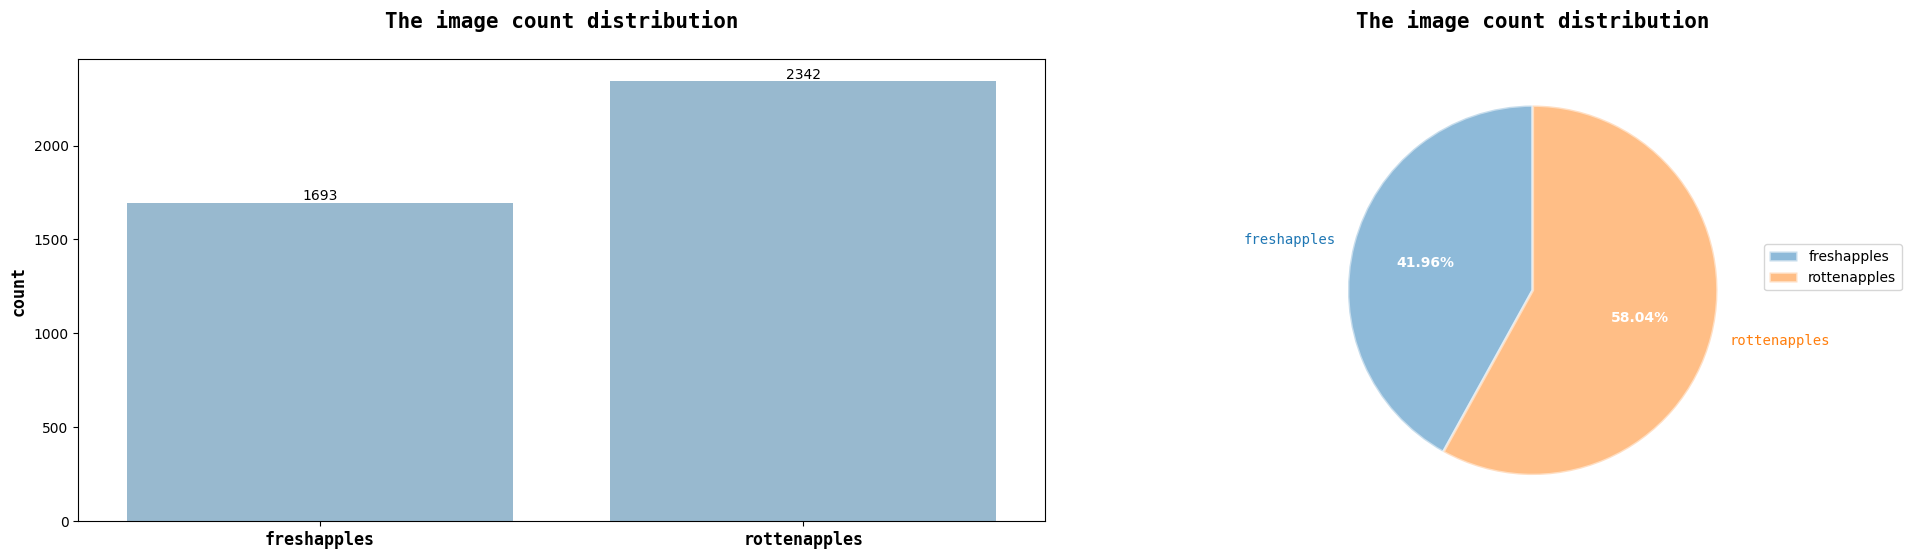

In [ ]:
fig,axes = plt.subplots(1,2,figsize=(25,6), gridspec_kw=dict(wspace=0.005))
sns.barplot(data=fruit_df, x='fruit_name', y='fruit_count',ax=axes[0], alpha=0.5)
for i in axes[0].get_xticklabels():
    i.set_font('monospace')
    i.set_weight('semibold')
    i.set_size(12)
for j in axes[0].containers:
    axes[0].bar_label(j)

axes[0].set_xlabel('')
axes[0].set_ylabel('count', font='monospace', weight='semibold', size=12)
axes[0].set_title('The image count distribution\n', font='monospace', weight='semibold', size=15)

patches, texts, pcts = axes[1].pie(fruit_df['fruit_count'], labels=fruit_df['fruit_name'], wedgeprops={'linewidth': 2, 'edgecolor': 'white'},
            textprops={'size': 'x-large'}, startangle=90, autopct='%1.2f%%');
for i, patch in enumerate(patches):
    texts[i].set_color(patch.get_facecolor())
    patch.set_alpha(0.5)
for j in pcts:
    j.set_size(10)
    j.set_color('white')
    j.set_weight('semibold')
plt.setp(texts, fontweight='semibold', font='monospace')
axes[1].legend(loc=[1,0.5])
axes[1].set_title('The image count distribution\n', font='monospace', weight='semibold', size=15);

In [ ]:
def get_image_range(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower = np.array([0, 0, 0], dtype = "uint8")
    upper = np.array([255, 50, 255], dtype = "uint8")
    img = cv2.inRange(img, lower, upper)
    img = cv2.blur(img, (2, 2))
    ret, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY)
    img = cv2.bitwise_not(thresh)
    contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = max(contours, key=lambda x: cv2.contourArea(x))

    #get bounding box posotion
    xmin, ymin, xmax, ymax = cv2.boundingRect(contours)

    #get the original width,height of the image
    dimensions = img.shape
    h = img.shape[0]
    w = img.shape[1]

    #to calculate the bndBox info of this image for yolo
    xp = (xmin + (xmax-xmin)/2) * 1.0 / w
    yp = (ymin + (ymax-ymin)/2) * 1.0 / h
    wp = (xmax-xmin) * 1.0 / w
    hp = (ymax-ymin) * 1.0 / h
    return xp, yp, wp, hp

In [ ]:
# def refine_with_anfis(bbox):
#     # Simulated ANFIS refinement logic
#     x_center, y_center, box_width, box_height = bbox
#     # Example: Increase box width and height by 5% as a simulated refinement
#     refined_width = box_width * 1.05
#     refined_height = box_height * 1.05
#     return x_center, y_center, refined_width, refined_height

In [ ]:
for dirname, _, filenames in os.walk(dataset_path):
    if dirname[1:].split('/')[-2]=='train':
        for img_path in glob.glob(dirname+'/*.png'):
            shutil.copy(img_path, os.path.join(train_img_dir, img_path.split('/')[-1]))
            label=0
            if img_path.split('/')[-2] == 'freshapples':
                label=0
            elif img_path.split('/')[-2] == 'rottenapples':
                label=1
            x_center, y_center, box_width, box_height = get_image_range(img_path)
            # Refine bounding box dimensions using the simulated ANFIS function
            # x_center, y_center, box_width, box_height = refine_with_anfis((x_center, y_center, box_width, box_height))
            text = str(label)+' '+str(x_center)+' '+str(y_center)+' '+str(box_width)+' '+str(box_height)
            with open (os.path.join(train_label_dir, img_path.split('/')[-1][:-4]+'.txt'),'w') as file:
                file.write(text)

    if dirname[1:].split('/')[-2]=='test':
        for img_path in glob.glob(dirname+'/*.png'):
            shutil.copy(img_path, os.path.join(test_img_dir, img_path.split('/')[-1]))
            label=0
            if img_path.split('/')[-2] == 'freshapples':
                label=0
            elif img_path.split('/')[-2] == 'rottenapples':
                label=1
            x_center, y_center, box_width, box_height = get_image_range(img_path)
            # Refine bounding box dimensions using the simulated ANFIS function
            # x_center, y_center, box_width, box_height = refine_with_anfis((x_center, y_center, box_width, box_height))
            text = str(label)+' '+str(x_center)+' '+str(y_center)+' '+str(box_width)+' '+str(box_height)
            with open (os.path.join(test_label_dir, img_path.split('/')[-1][:-4]+'.txt'),'w') as file:
                file.write(text)

In [ ]:
print(f'There are {len(os.listdir(train_img_dir))} train images')
print(f'There are {len(os.listdir(train_label_dir))} corresponding train labels\n')

print(f'There are {len(os.listdir(test_img_dir))} train images')
print(f'There are {len(os.listdir(test_label_dir))} corresponding test labels')

There are 4035 train images
There are 4035 corresponding train labels

There are 996 train images
There are 996 corresponding test labels


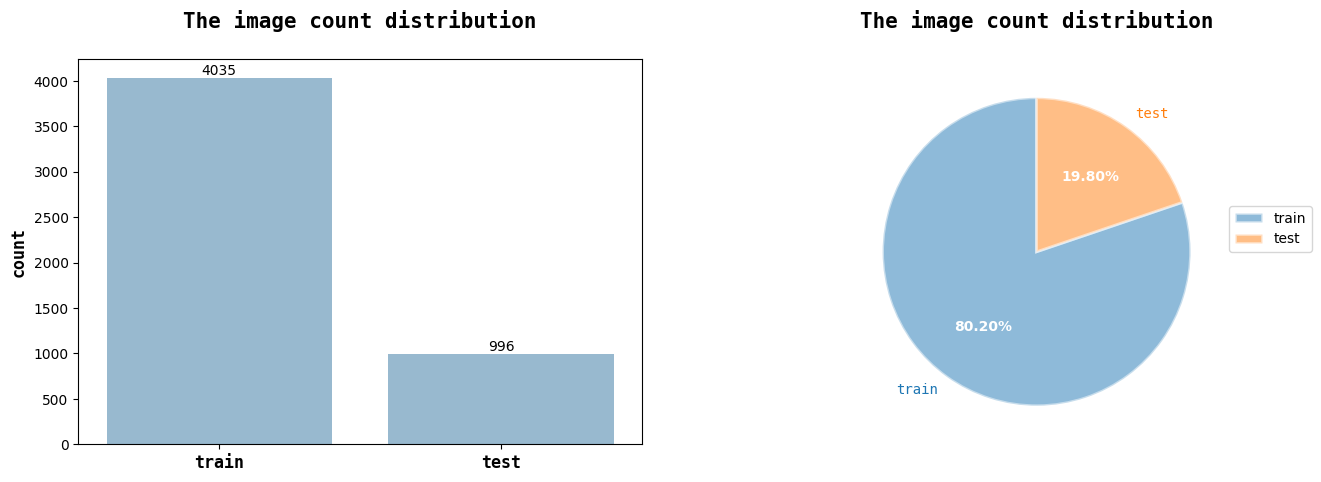

In [ ]:
df = pd.DataFrame({'file':['train', 'test'], 'count':[len(os.listdir(train_img_dir)),len(os.listdir(test_img_dir))]})
fig,axes = plt.subplots(1,2,figsize=(16,5))
sns.barplot(data=df.reset_index(), x='file', y='count',ax=axes[0], alpha=0.5)
for i in axes[0].get_xticklabels():
    i.set_font('monospace')
    i.set_weight('semibold')
    i.set_size(12)
for j in axes[0].containers:
    axes[0].bar_label(j)

axes[0].set_xlabel('')
axes[0].set_ylabel('count', font='monospace', weight='semibold', size=12)
axes[0].set_title('The image count distribution\n', font='monospace', weight='semibold', size=15)

patches, texts, pcts = axes[1].pie(df['count'], labels=df['file'], wedgeprops={'linewidth': 2, 'edgecolor': 'white'},
            textprops={'size': 'x-large'}, startangle=90, autopct='%1.2f%%');
for i, patch in enumerate(patches):
    texts[i].set_color(patch.get_facecolor())
    patch.set_alpha(0.5)
for j in pcts:
    j.set_size(10)
    j.set_color('white')
    j.set_weight('semibold')
plt.setp(texts, fontweight='semibold', font='monospace')
axes[1].legend(loc=[1,0.5])
axes[1].set_title('The image count distribution\n', font='monospace', weight='semibold', size=15);

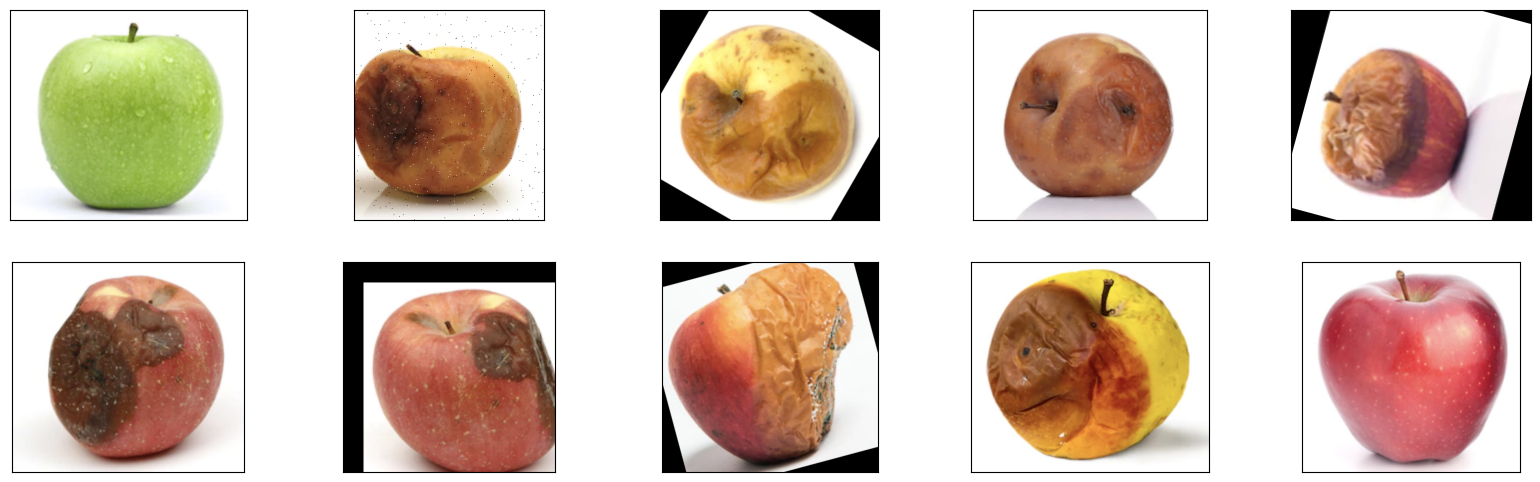

In [ ]:
img_path=[]
selected_img = random.sample([i for i in os.listdir(train_img_dir)], 10)
for i in selected_img:
    img_path.append(os.path.join(train_img_dir, i))


fig, axes = plt.subplots(2,5, figsize=(20,6), subplot_kw=dict(xticks=[], yticks=[]))
for i, ax in enumerate(axes.flat):
    ax.imshow(np.array(PIL.Image.open(img_path[i])))

In [ ]:
yaml_file = """names:
- fresh_apples
- rotten_apples
nc: 2
train: /content/fresh_or_rotten/train/images
val: /content/fresh_or_rotten/test/images
"""

with open('/content/fresh_or_rotten/data.yaml', 'w') as f:
    f.write(yaml_file)

In [ ]:
with open(os.path.join(train_label_dir, os.listdir(train_label_dir)[0]),'r') as f:
    c = f.read()
    print(c)

1 0.4797619047619048 0.48582474226804123 0.5119047619047619 0.47164948453608246


In [ ]:
pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.4/750.4 kB 4.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
from ultralytics import YOLO
import os
from IPython.display import display, Image
from IPython import display

In [ ]:
! yolo checks

Ultralytics YOLOv8.1.47 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 30.9/78.2 GB disk)

OS                  Linux-6.1.58+-x86_64-with-glibc2.35
Environment         Colab
Python              3.10.12
Install             pip
RAM                 12.67 GB
CPU                 Intel Xeon 2.30GHz
CUDA                12.1

matplotlib          ✅ 3.7.1>=3.3.0
opencv-python       ✅ 4.8.0.76>=4.6.0
pillow              ✅ 9.4.0>=7.1.2
pyyaml              ✅ 6.0.1>=5.3.1
requests            ✅ 2.31.0>=2.23.0
scipy               ✅ 1.11.4>=1.4.1
torch               ✅ 2.2.1+cu121>=1.8.0
torchvision         ✅ 0.17.1+cu121>=0.9.0
tqdm                ✅ 4.66.2>=4.64.0
psutil              ✅ 5.9.5
py-cpuinfo          ✅ 9.0.0
thop                ✅ 0.1.1-2209072238>=0.1.1
pandas              ✅ 2.0.3>=1.1.4
seaborn             ✅ 0.13.1>=0.11.0


In [ ]:
!pip install torch torchvision torchaudio

In [ ]:
#  !yolo task=detect mode=train model=yolov8x.pt data=/content/fresh_or_rotten/data.yaml epochs=8 imgsz=640 optimizer=SGD

In [ ]:
 !yolo task=detect mode=train model=yolov8x.pt data=/content/fresh_or_rotten/data.yaml epochs=8 imgsz=640

100% 131M/131M [00:00<00:00, 185MB/s]
Ultralytics YOLOv8.1.47 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=/content/fresh_or_rotten/data.yaml, epochs=8, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=F

In [ ]:
os.listdir('/content/runs/detect/train')

['P_curve.png',
 'val_batch0_pred.jpg',
 'R_curve.png',
 'events.out.tfevents.1713183189.a6053f11f8cc.1495.0',
 'val_batch2_labels.jpg',
 'labels_correlogram.jpg',
 'train_batch1.jpg',
 'labels.jpg',
 'F1_curve.png',
 'train_batch0.jpg',
 'weights',
 'confusion_matrix.png',
 'train_batch2.jpg',
 'val_batch0_labels.jpg',
 'confusion_matrix_normalized.png',
 'results.csv',
 'args.yaml',
 'val_batch1_labels.jpg',
 'PR_curve.png',
 'results.png',
 'val_batch2_pred.jpg',
 'val_batch1_pred.jpg']

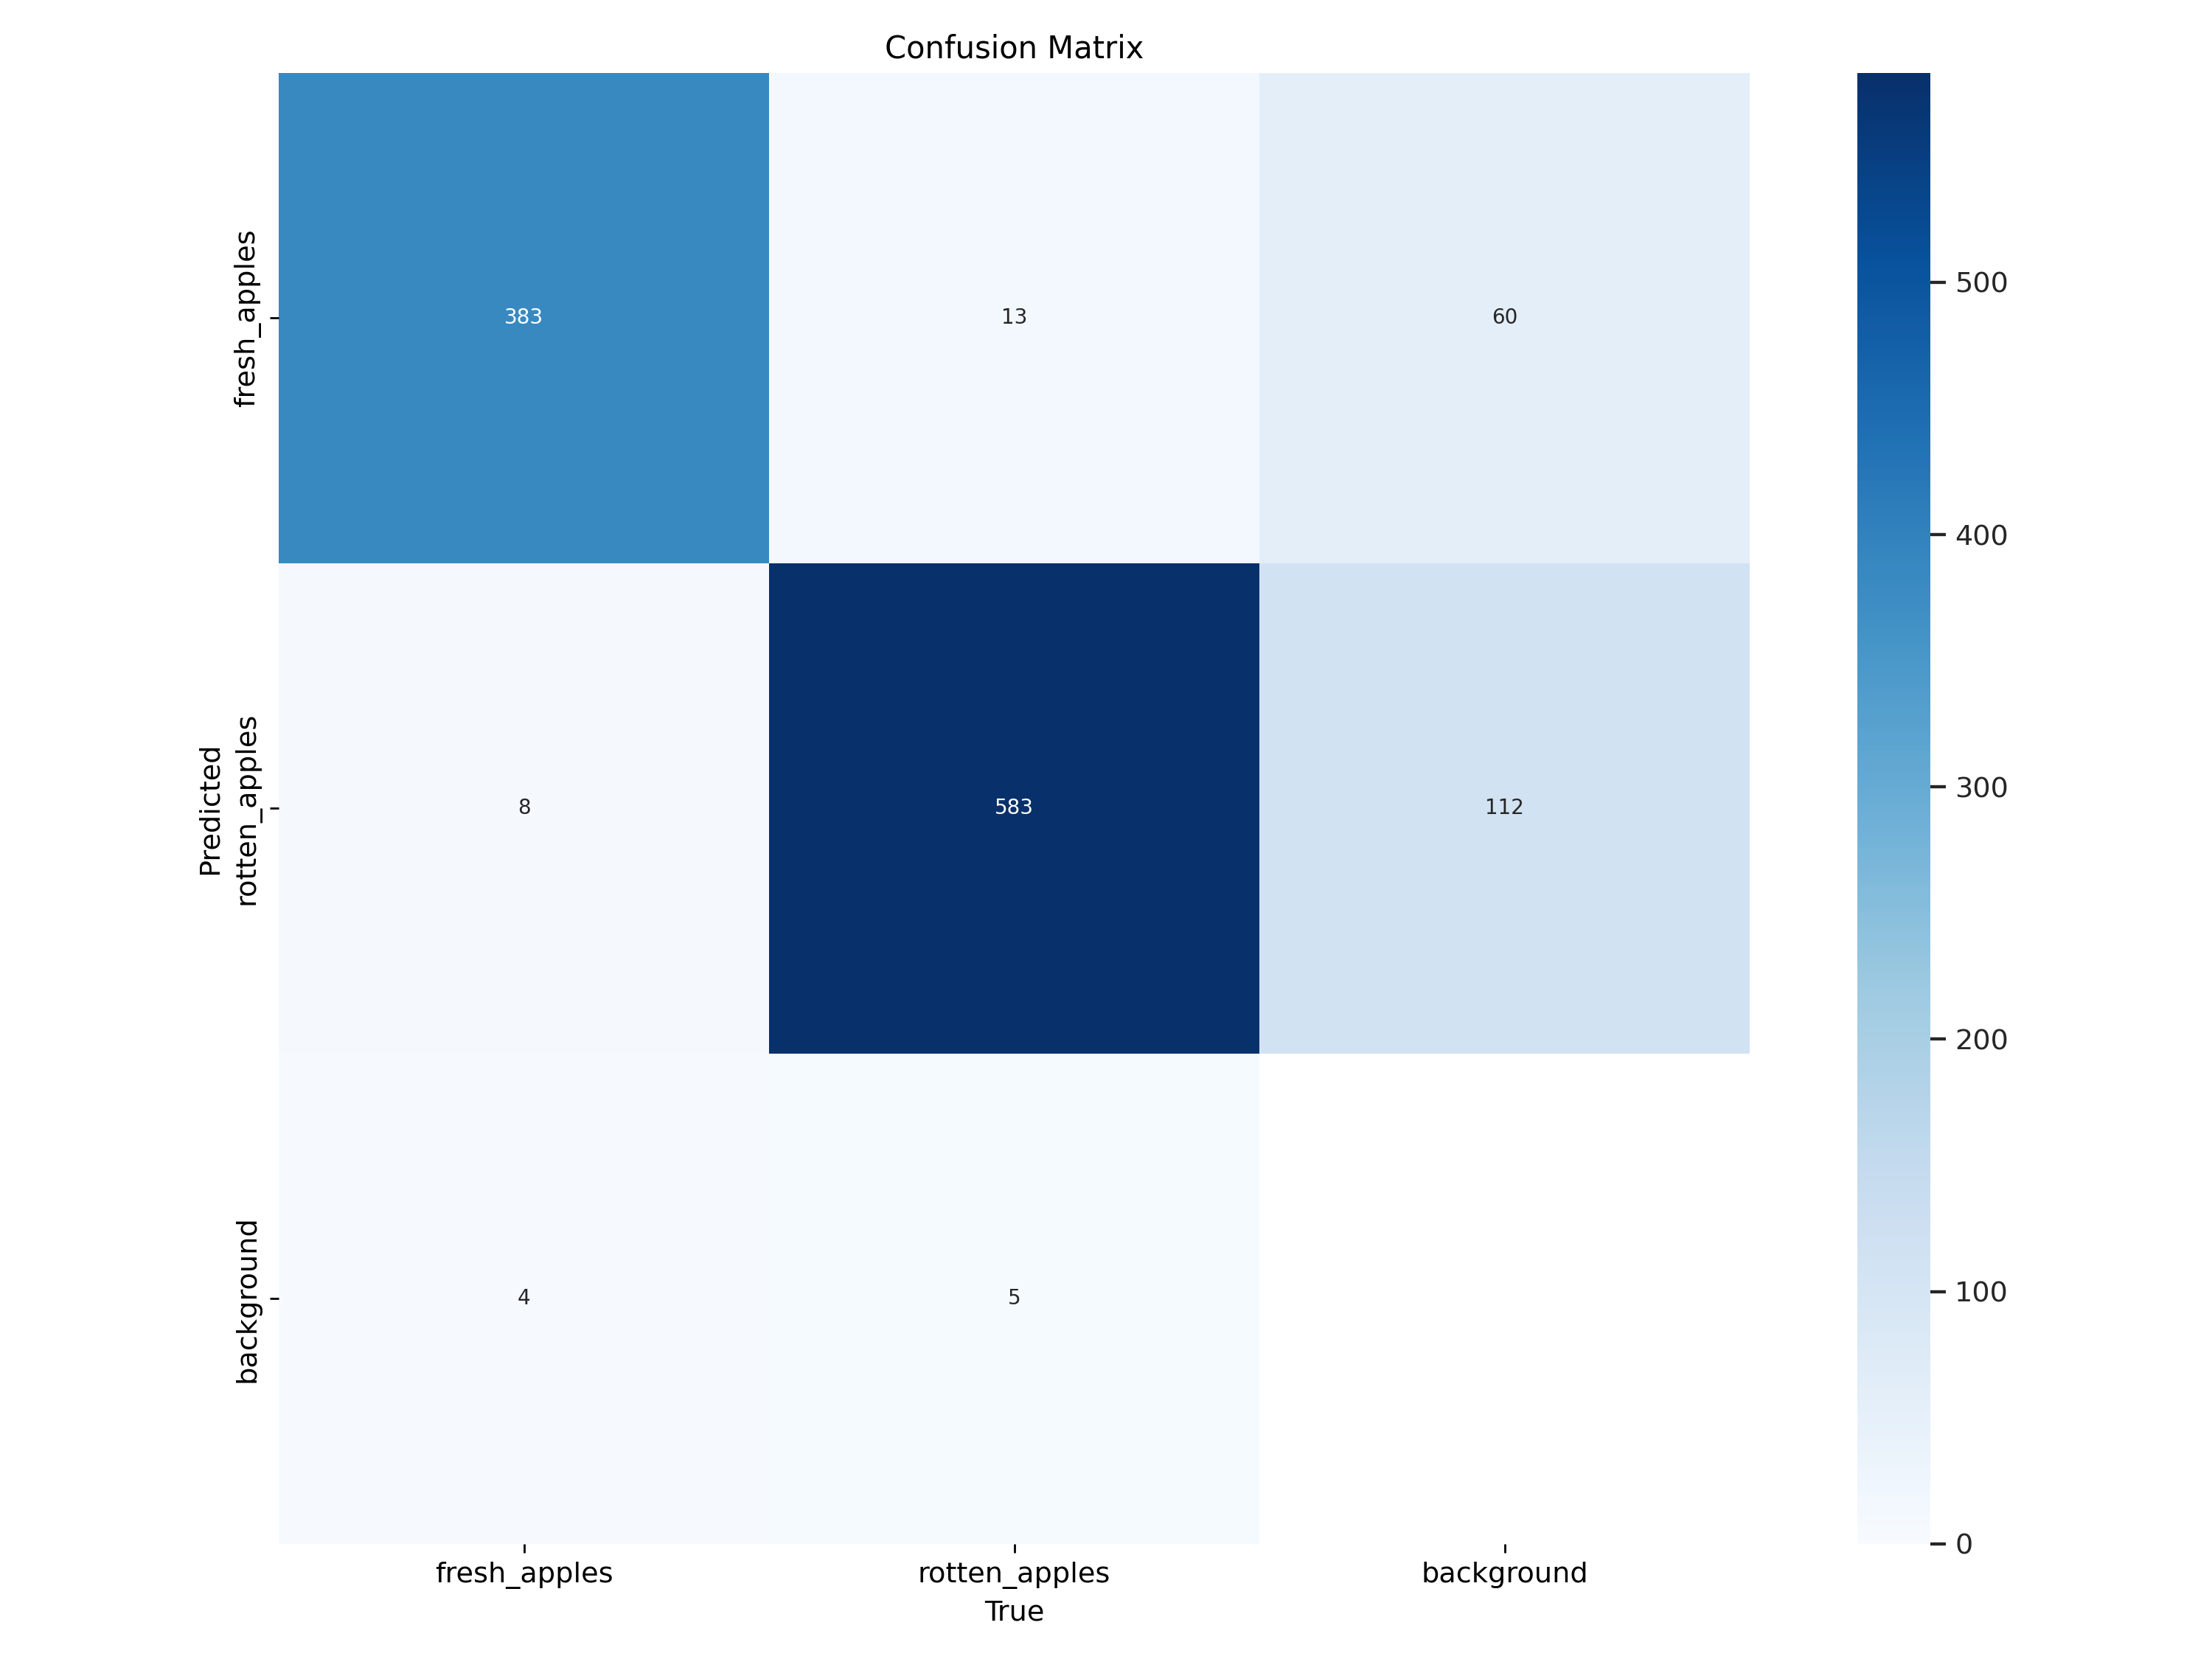

In [ ]:
Image('/content/runs/detect/train/confusion_matrix.png')

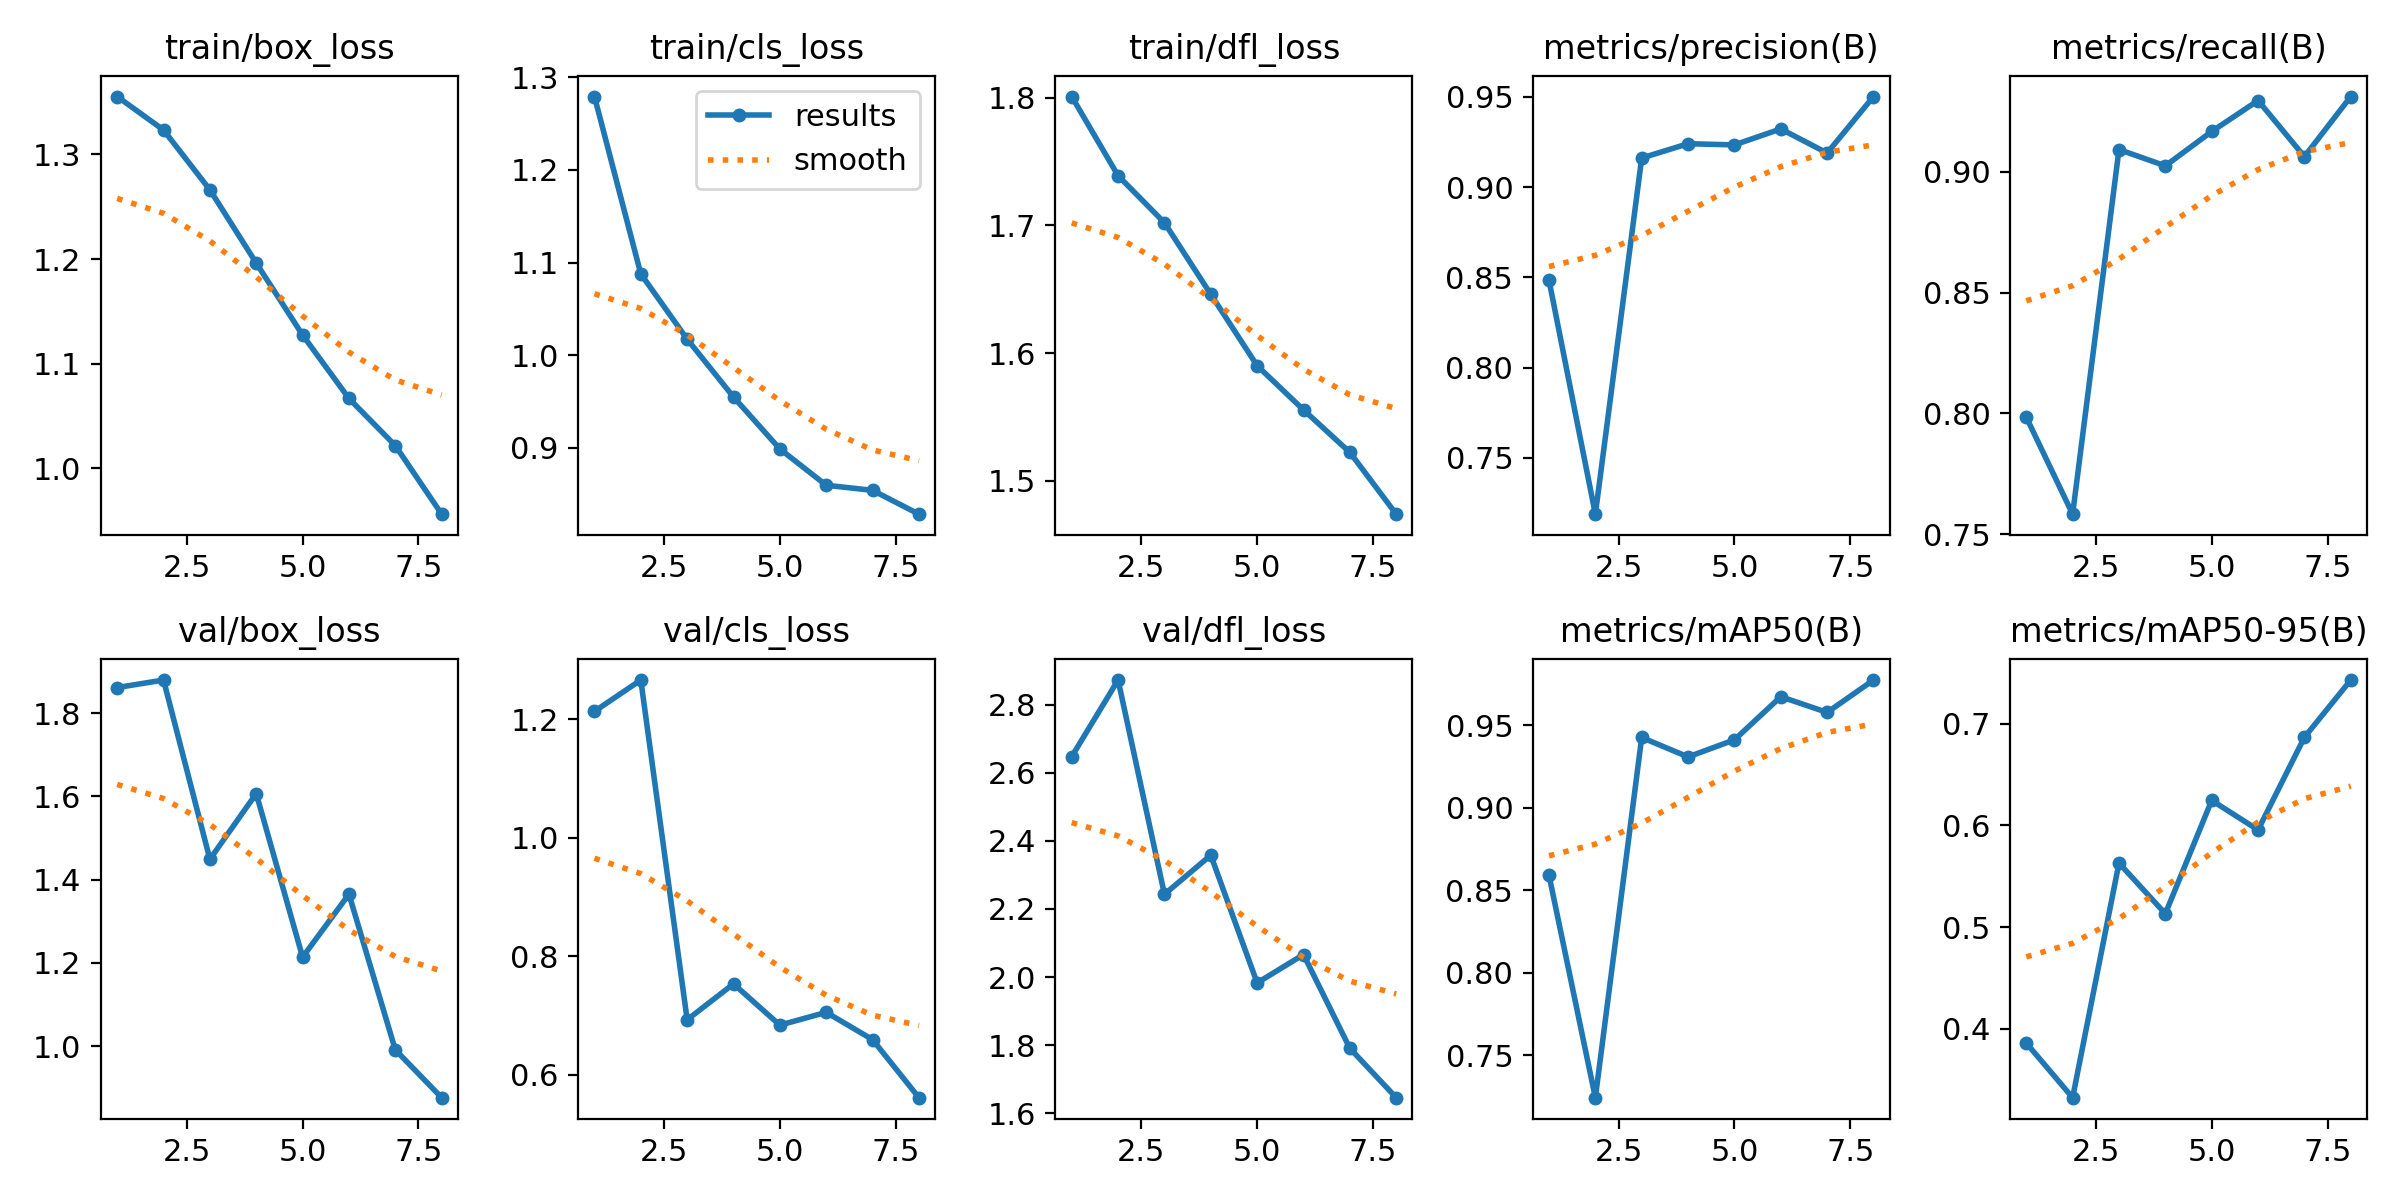

In [ ]:
Image('/content/runs/detect/train/results.png')

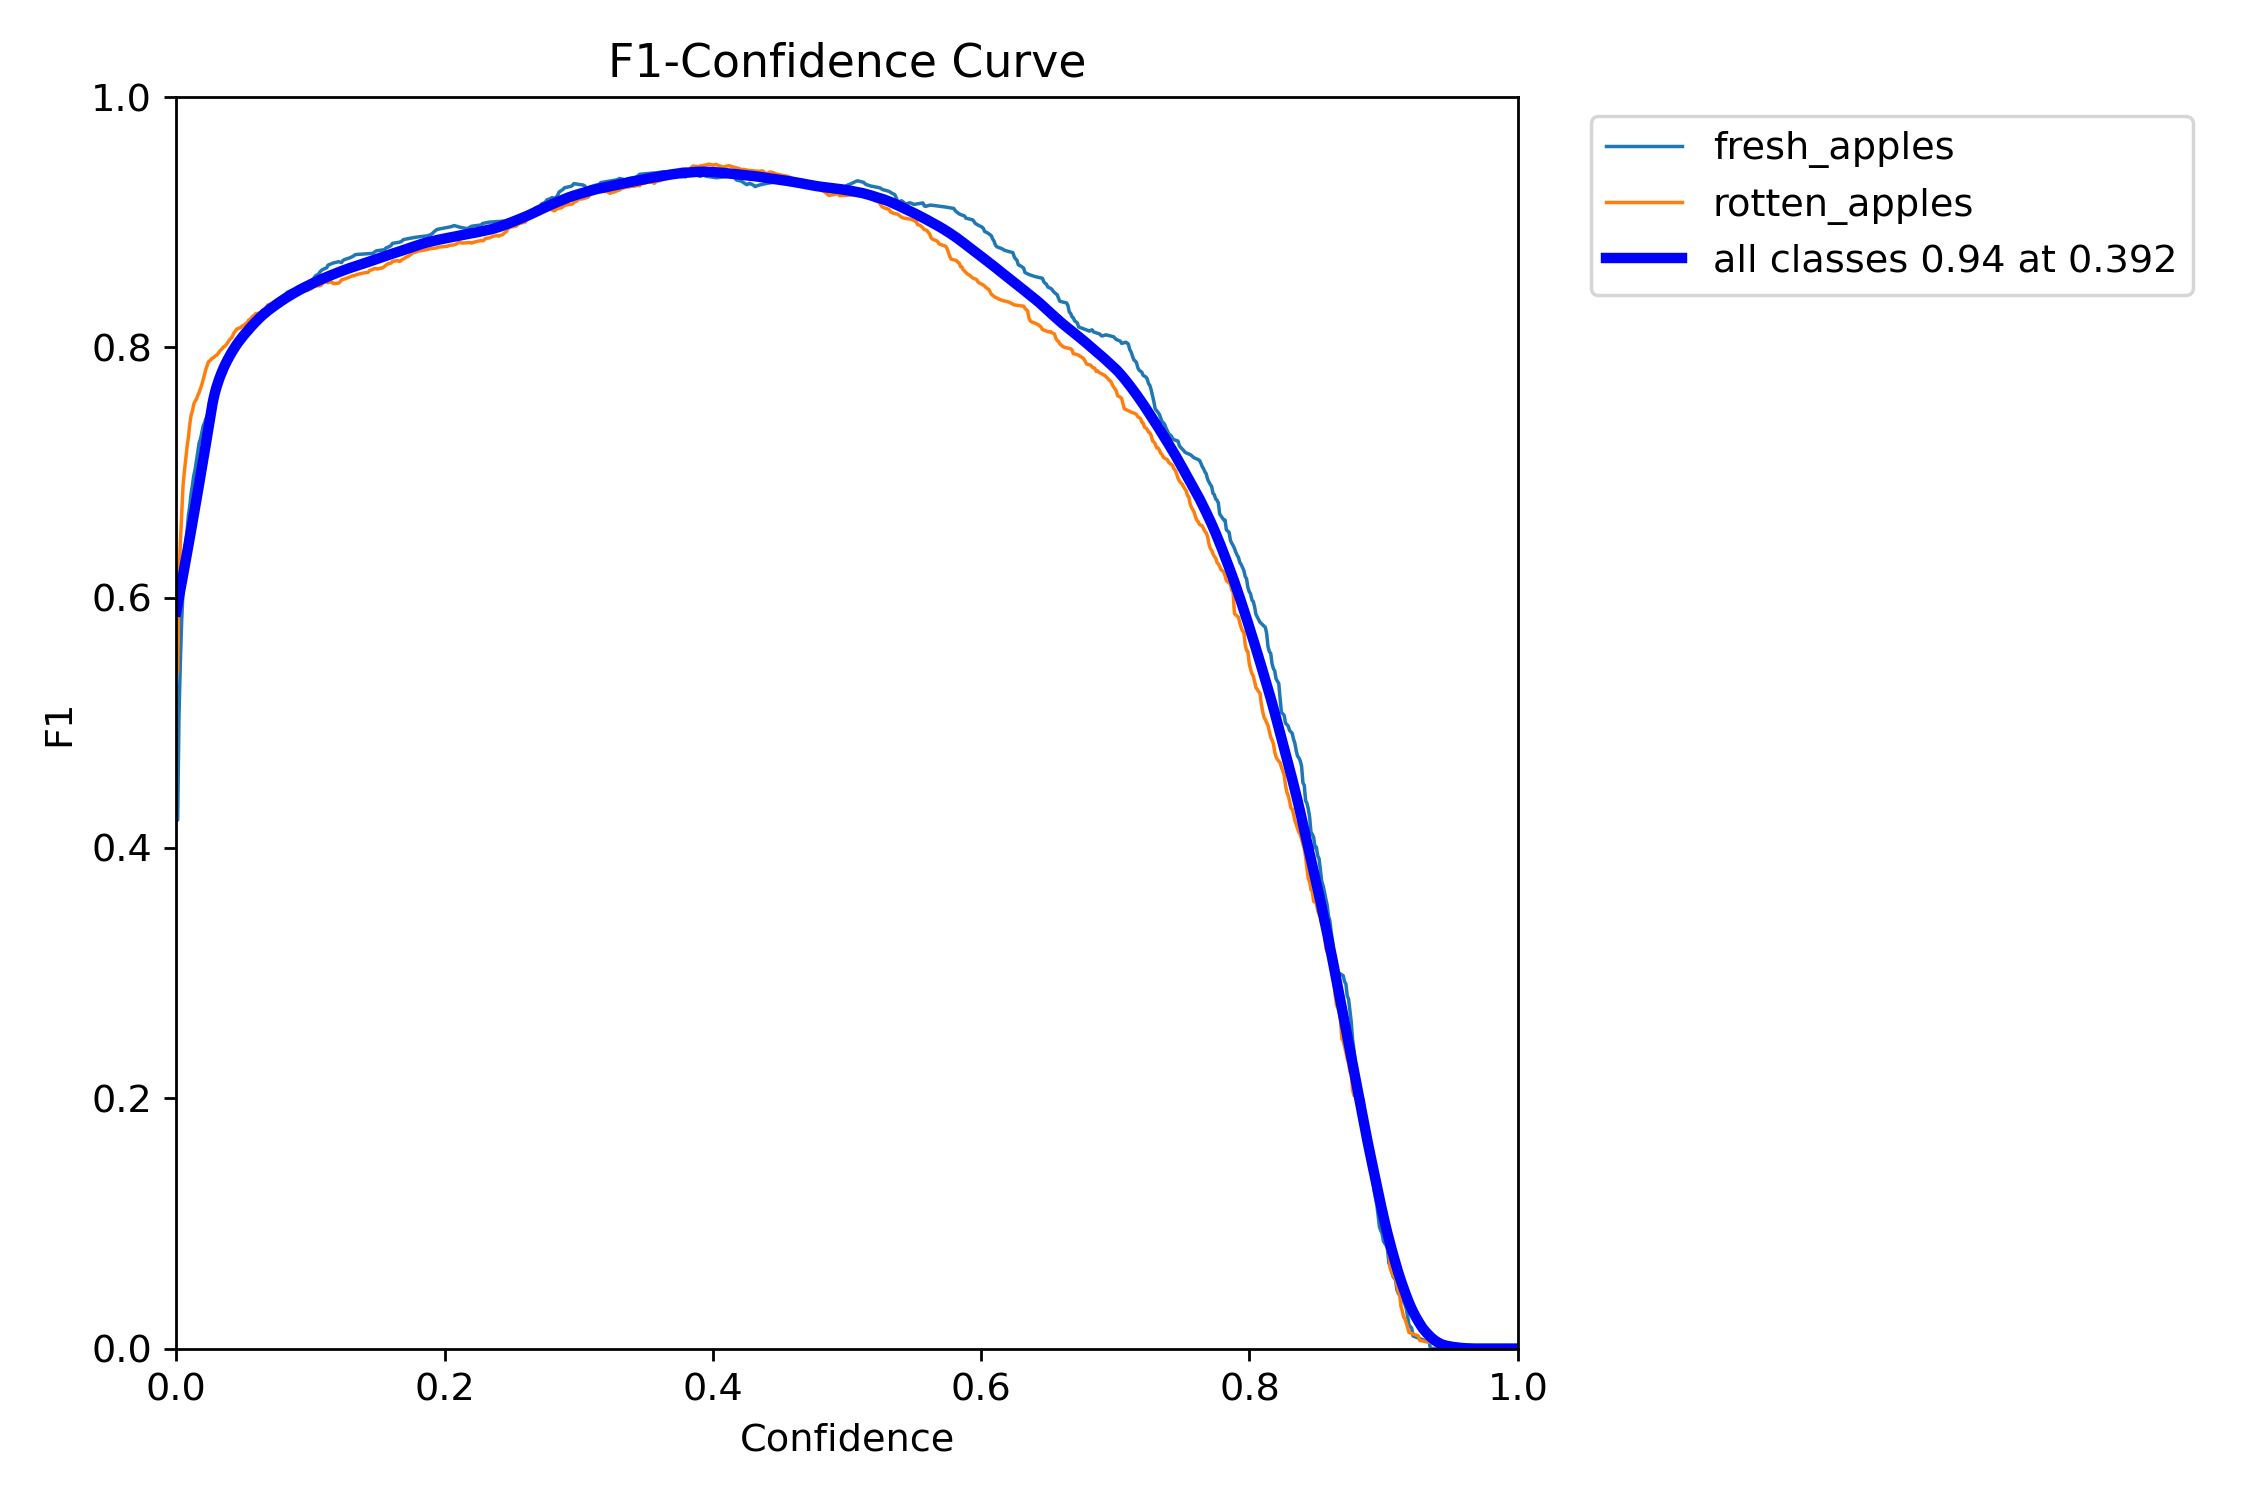

In [ ]:
Image(filename = '/content/runs/detect/train/F1_curve.png')

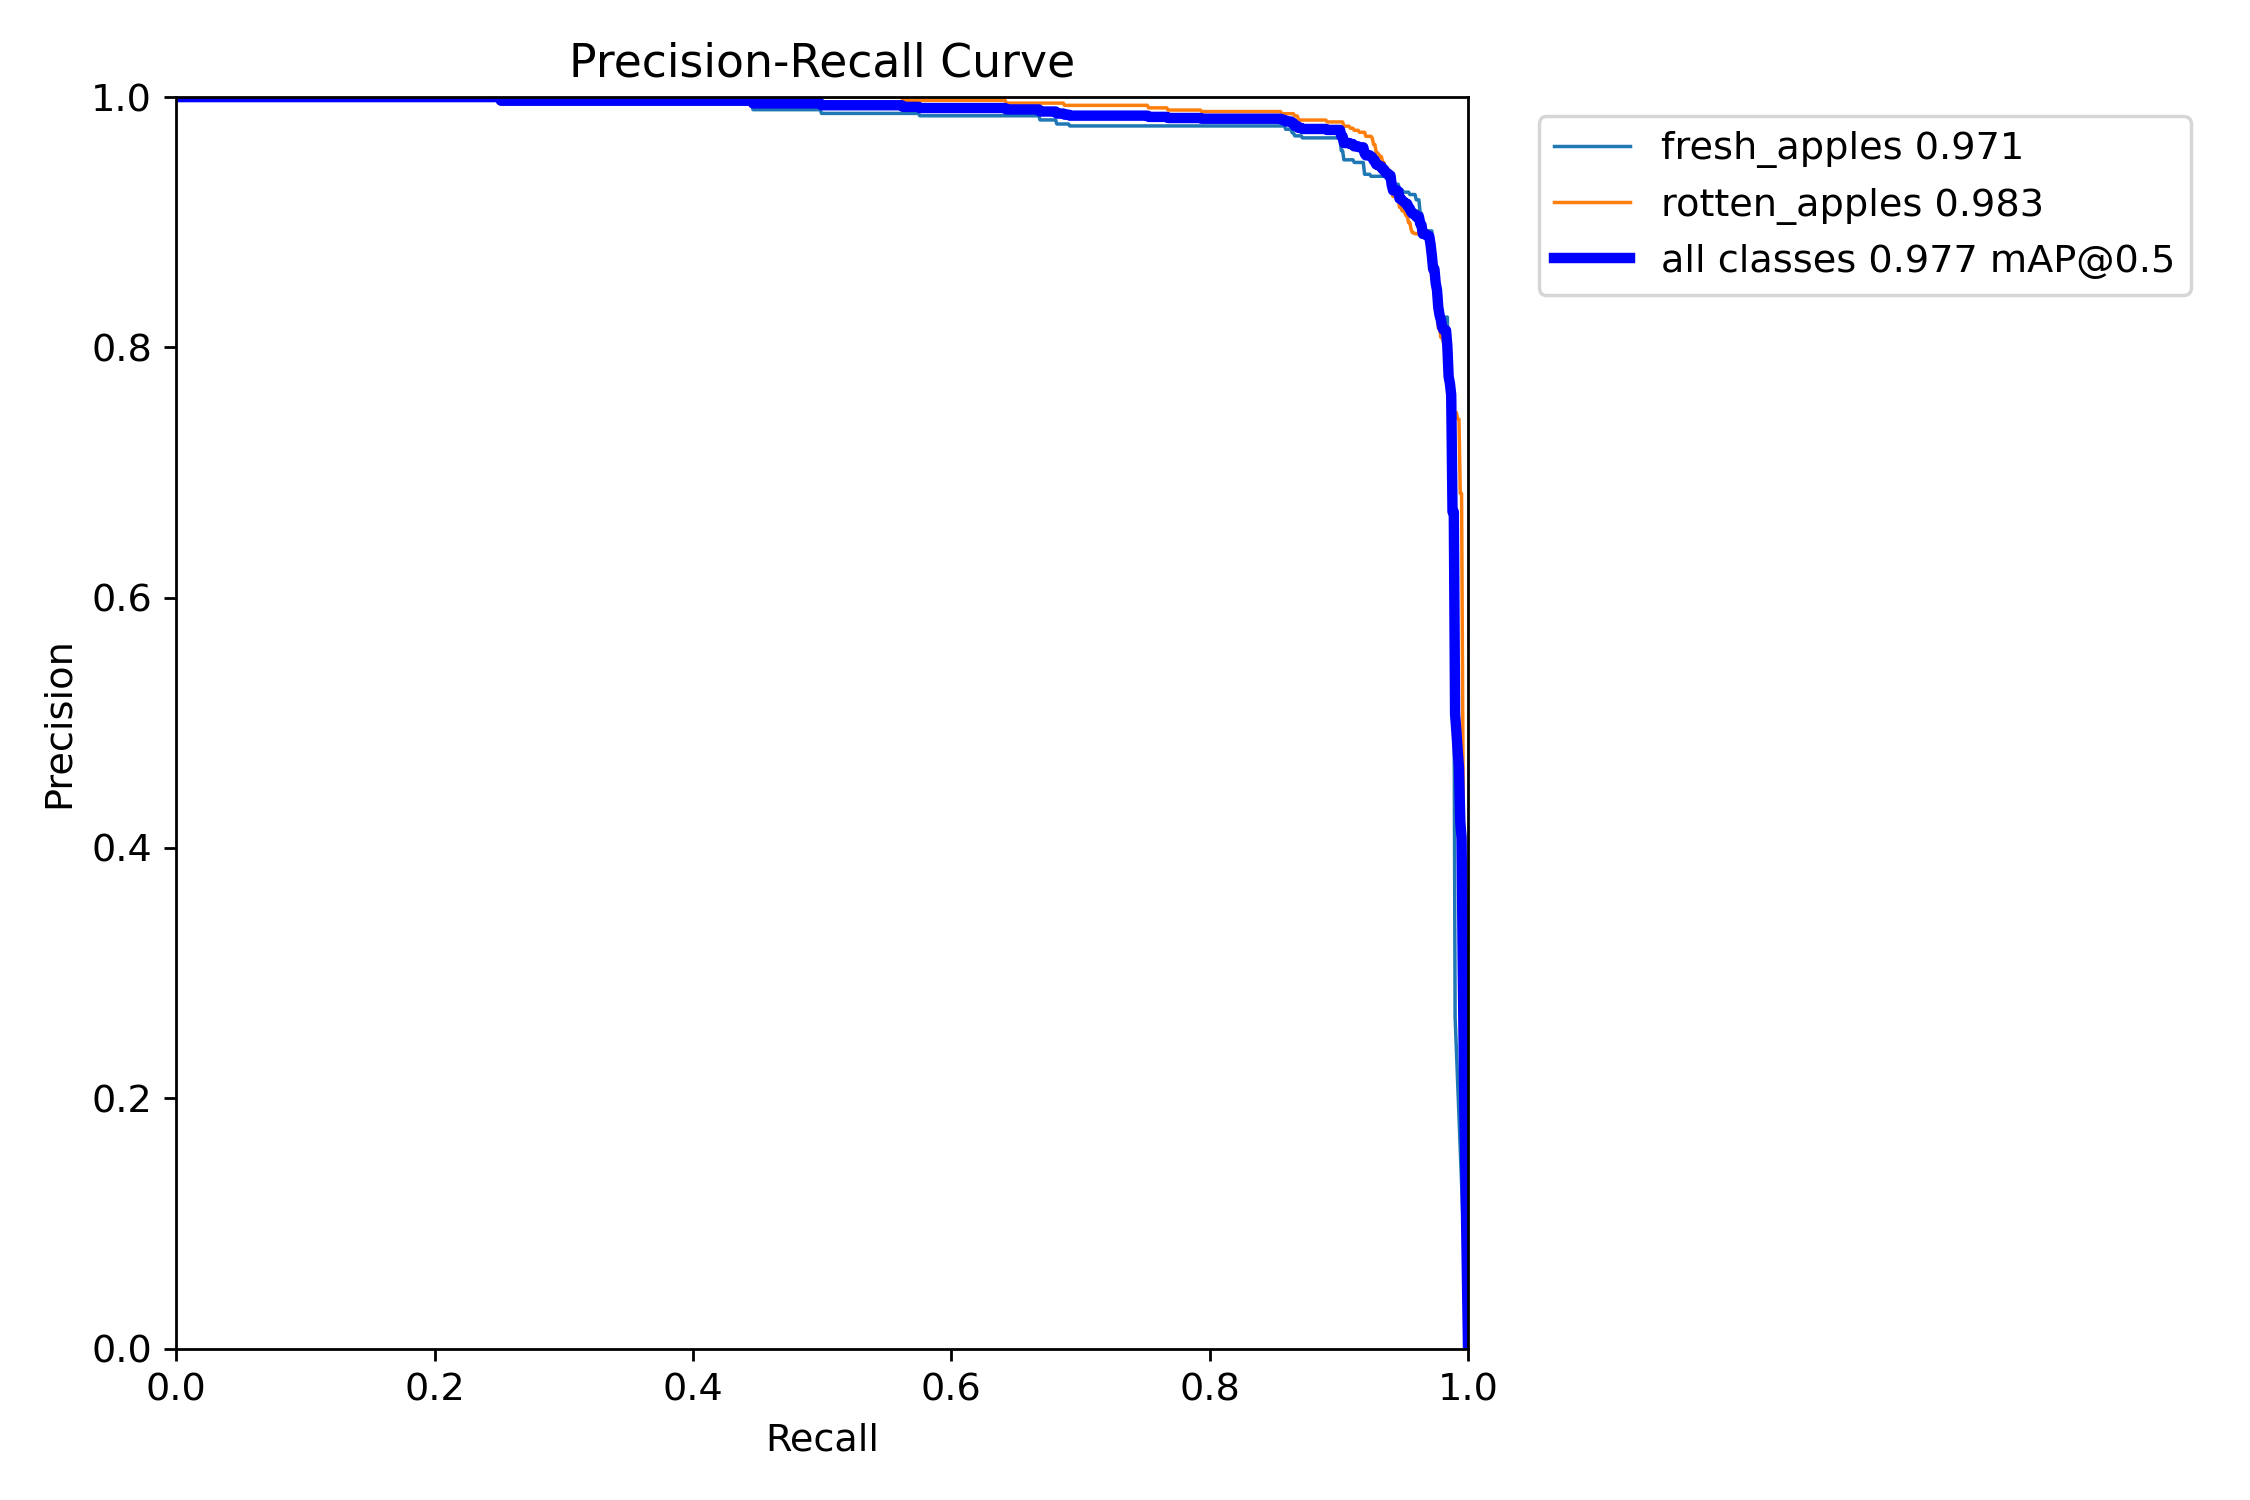

In [ ]:
Image(filename = '/content/runs/detect/train/PR_curve.png')

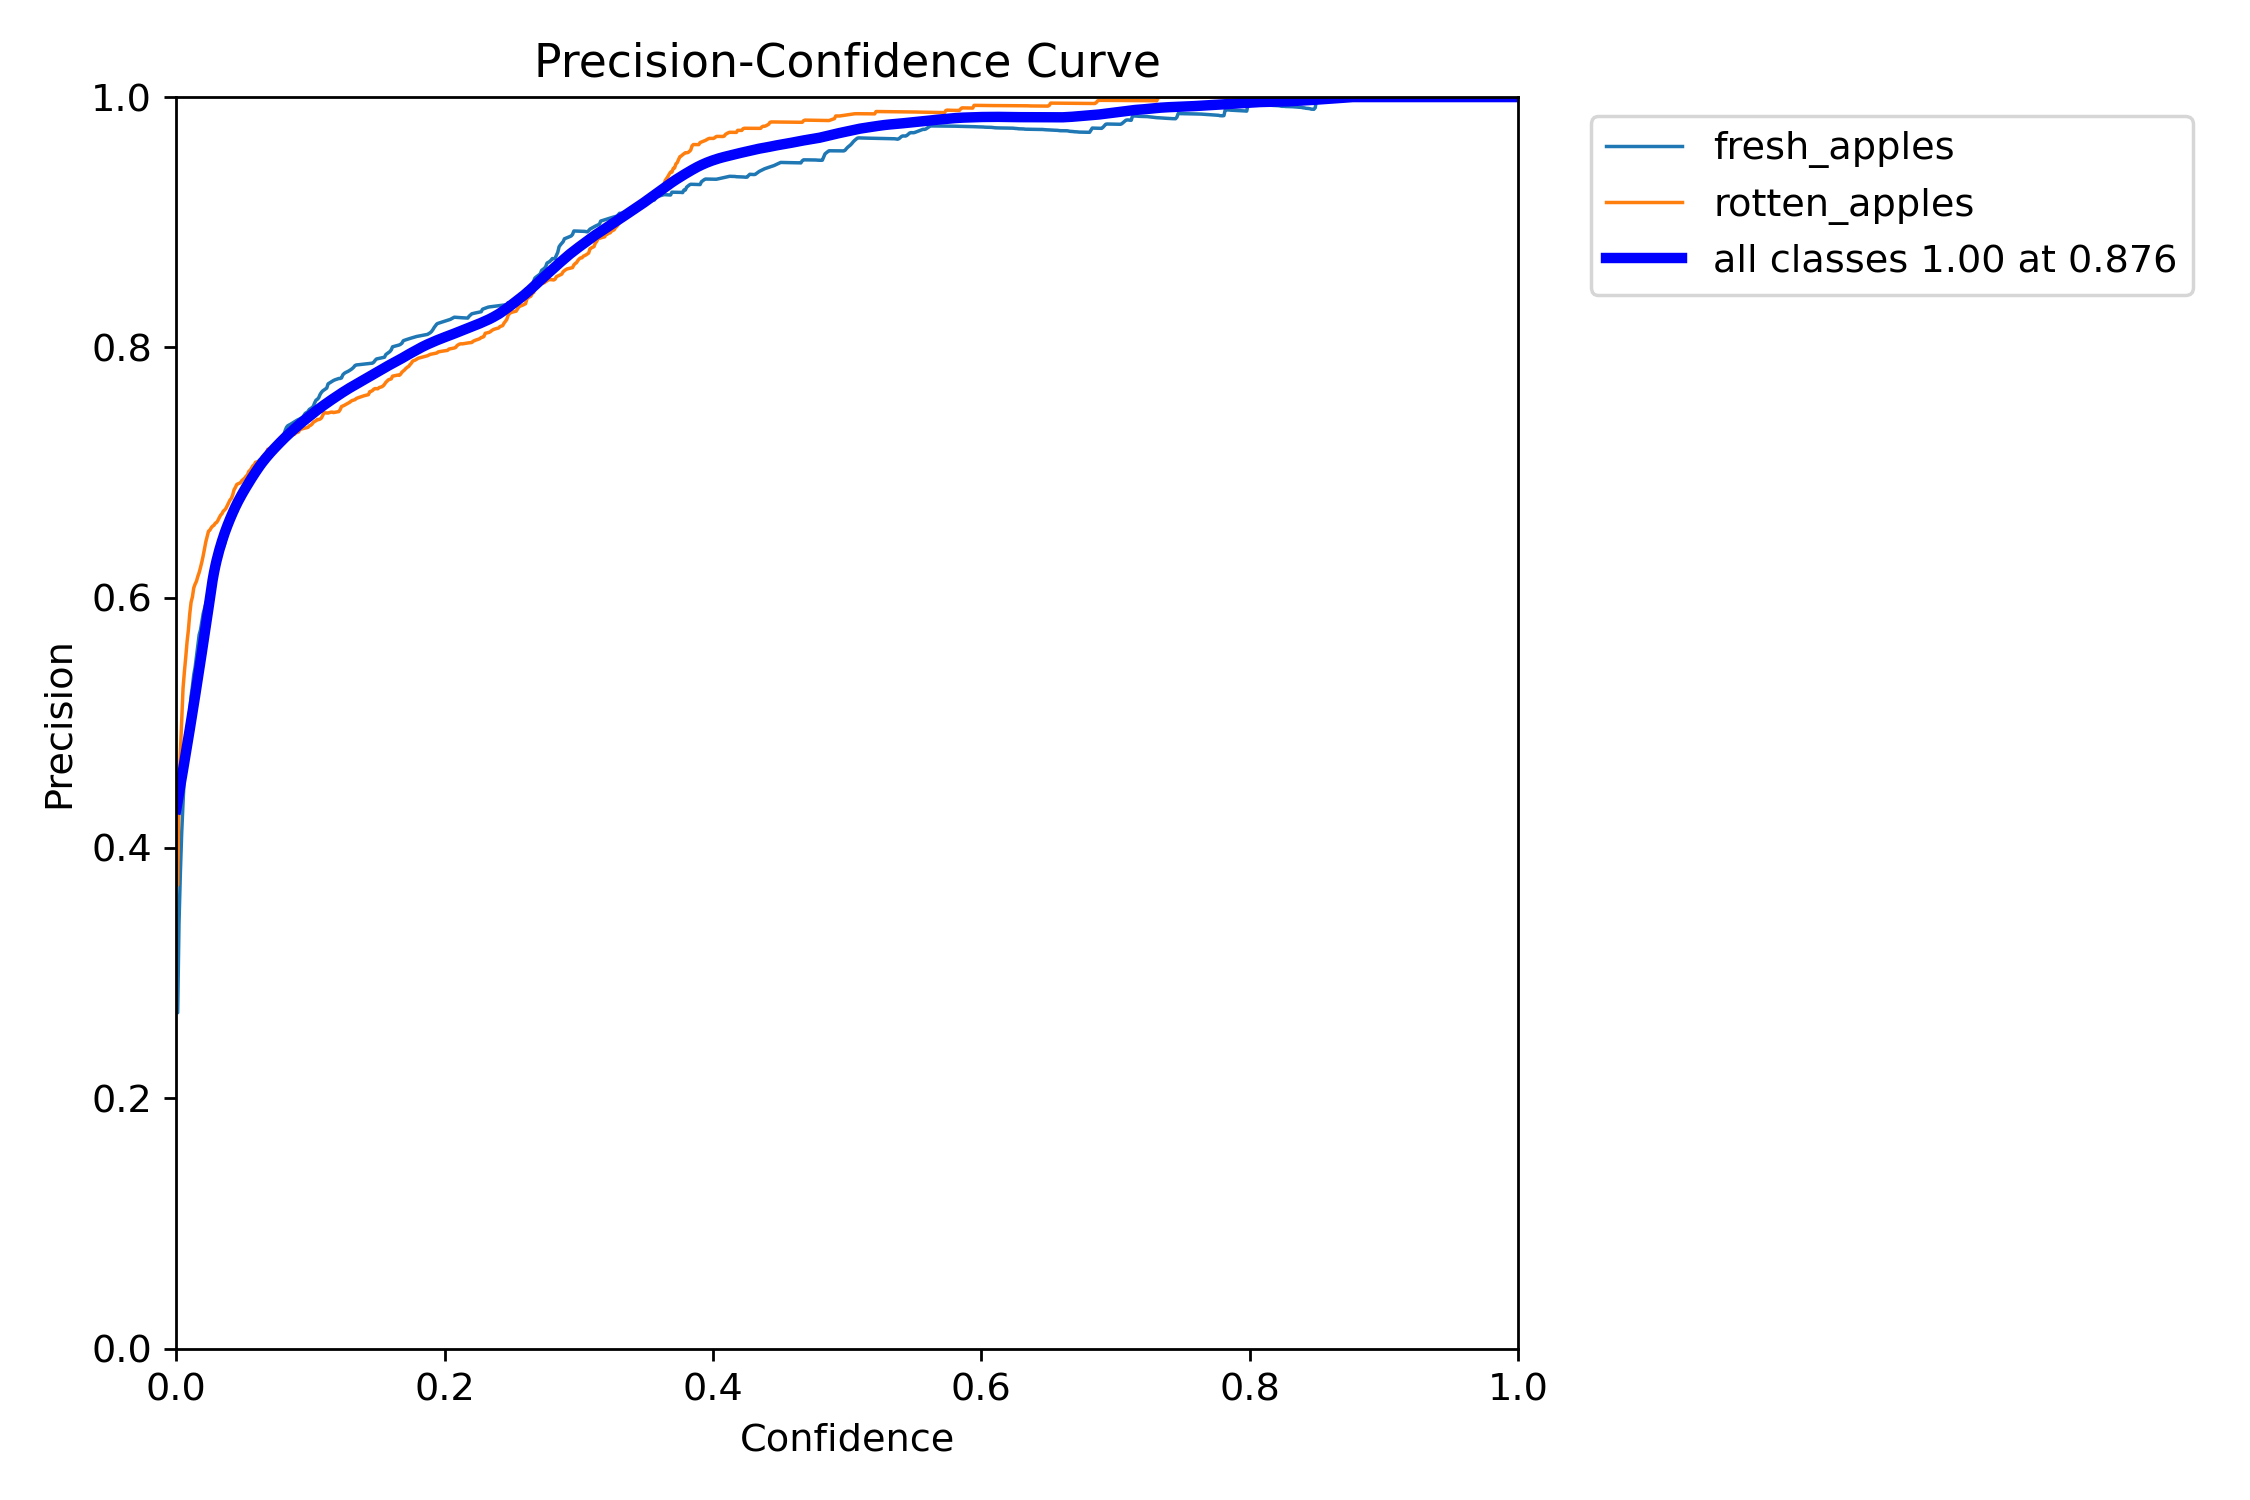

In [ ]:
Image(filename = '/content/runs/detect/train/P_curve.png')

In [ ]:
shutil.copy('/content/runs/detect/train/weights/best.pt','/content')

'/content/best.pt'

In [ ]:
! yolo task=detect mode=val model=/content/runs/detect/train/weights/best.pt data=/content/fresh_or_rotten/data.yaml

Ultralytics YOLOv8.1.47 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 268 layers, 68125494 parameters, 0 gradients, 257.4 GFLOPs
val: Scanning /content/fresh_or_rotten/test/labels.cache... 996 images, 0 backgrounds, 0 corrupt: 100% 996/996 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 63/63 [01:12<00:00,  1.14s/it]
                   all        996        996      0.951       0.93      0.977      0.742
          fresh_apples        996        395      0.934      0.937      0.972       0.73
         rotten_apples        996        601      0.967      0.923      0.983      0.754
Speed: 0.9ms preprocess, 59.8ms inference, 0.0ms loss, 5.5ms postprocess per image
Results saved to runs/detect/val
💡 Learn more at https://docs.ultralytics.com/modes/val


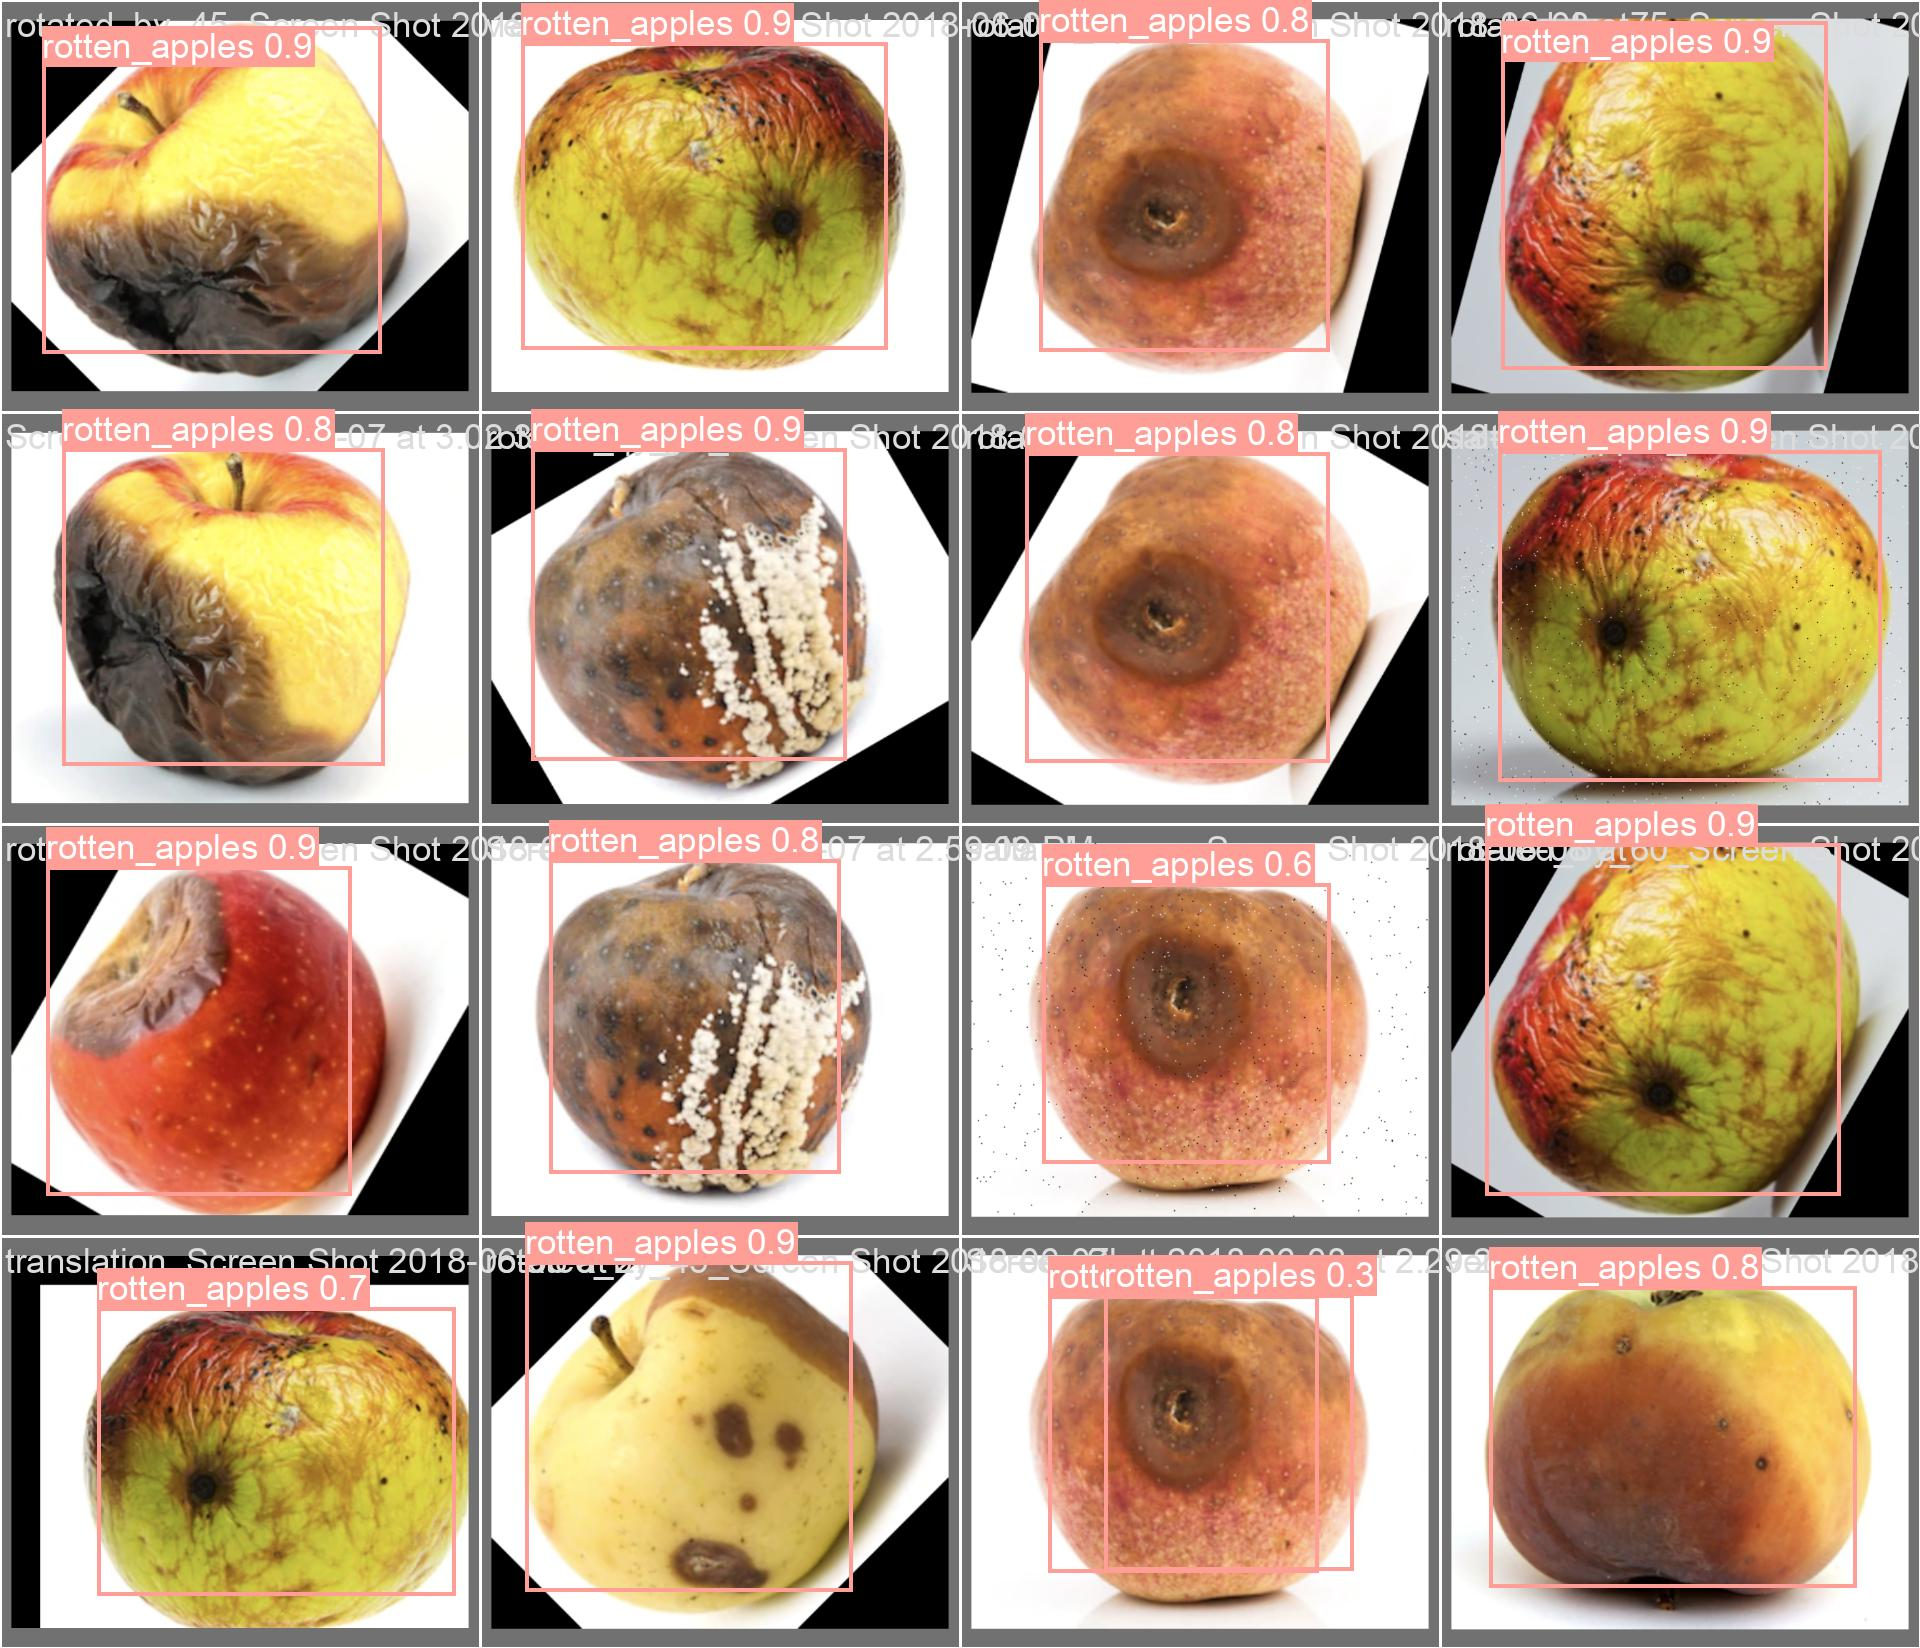

In [ ]:
Image(filename = '/content/runs/detect/train/val_batch1_pred.jpg')

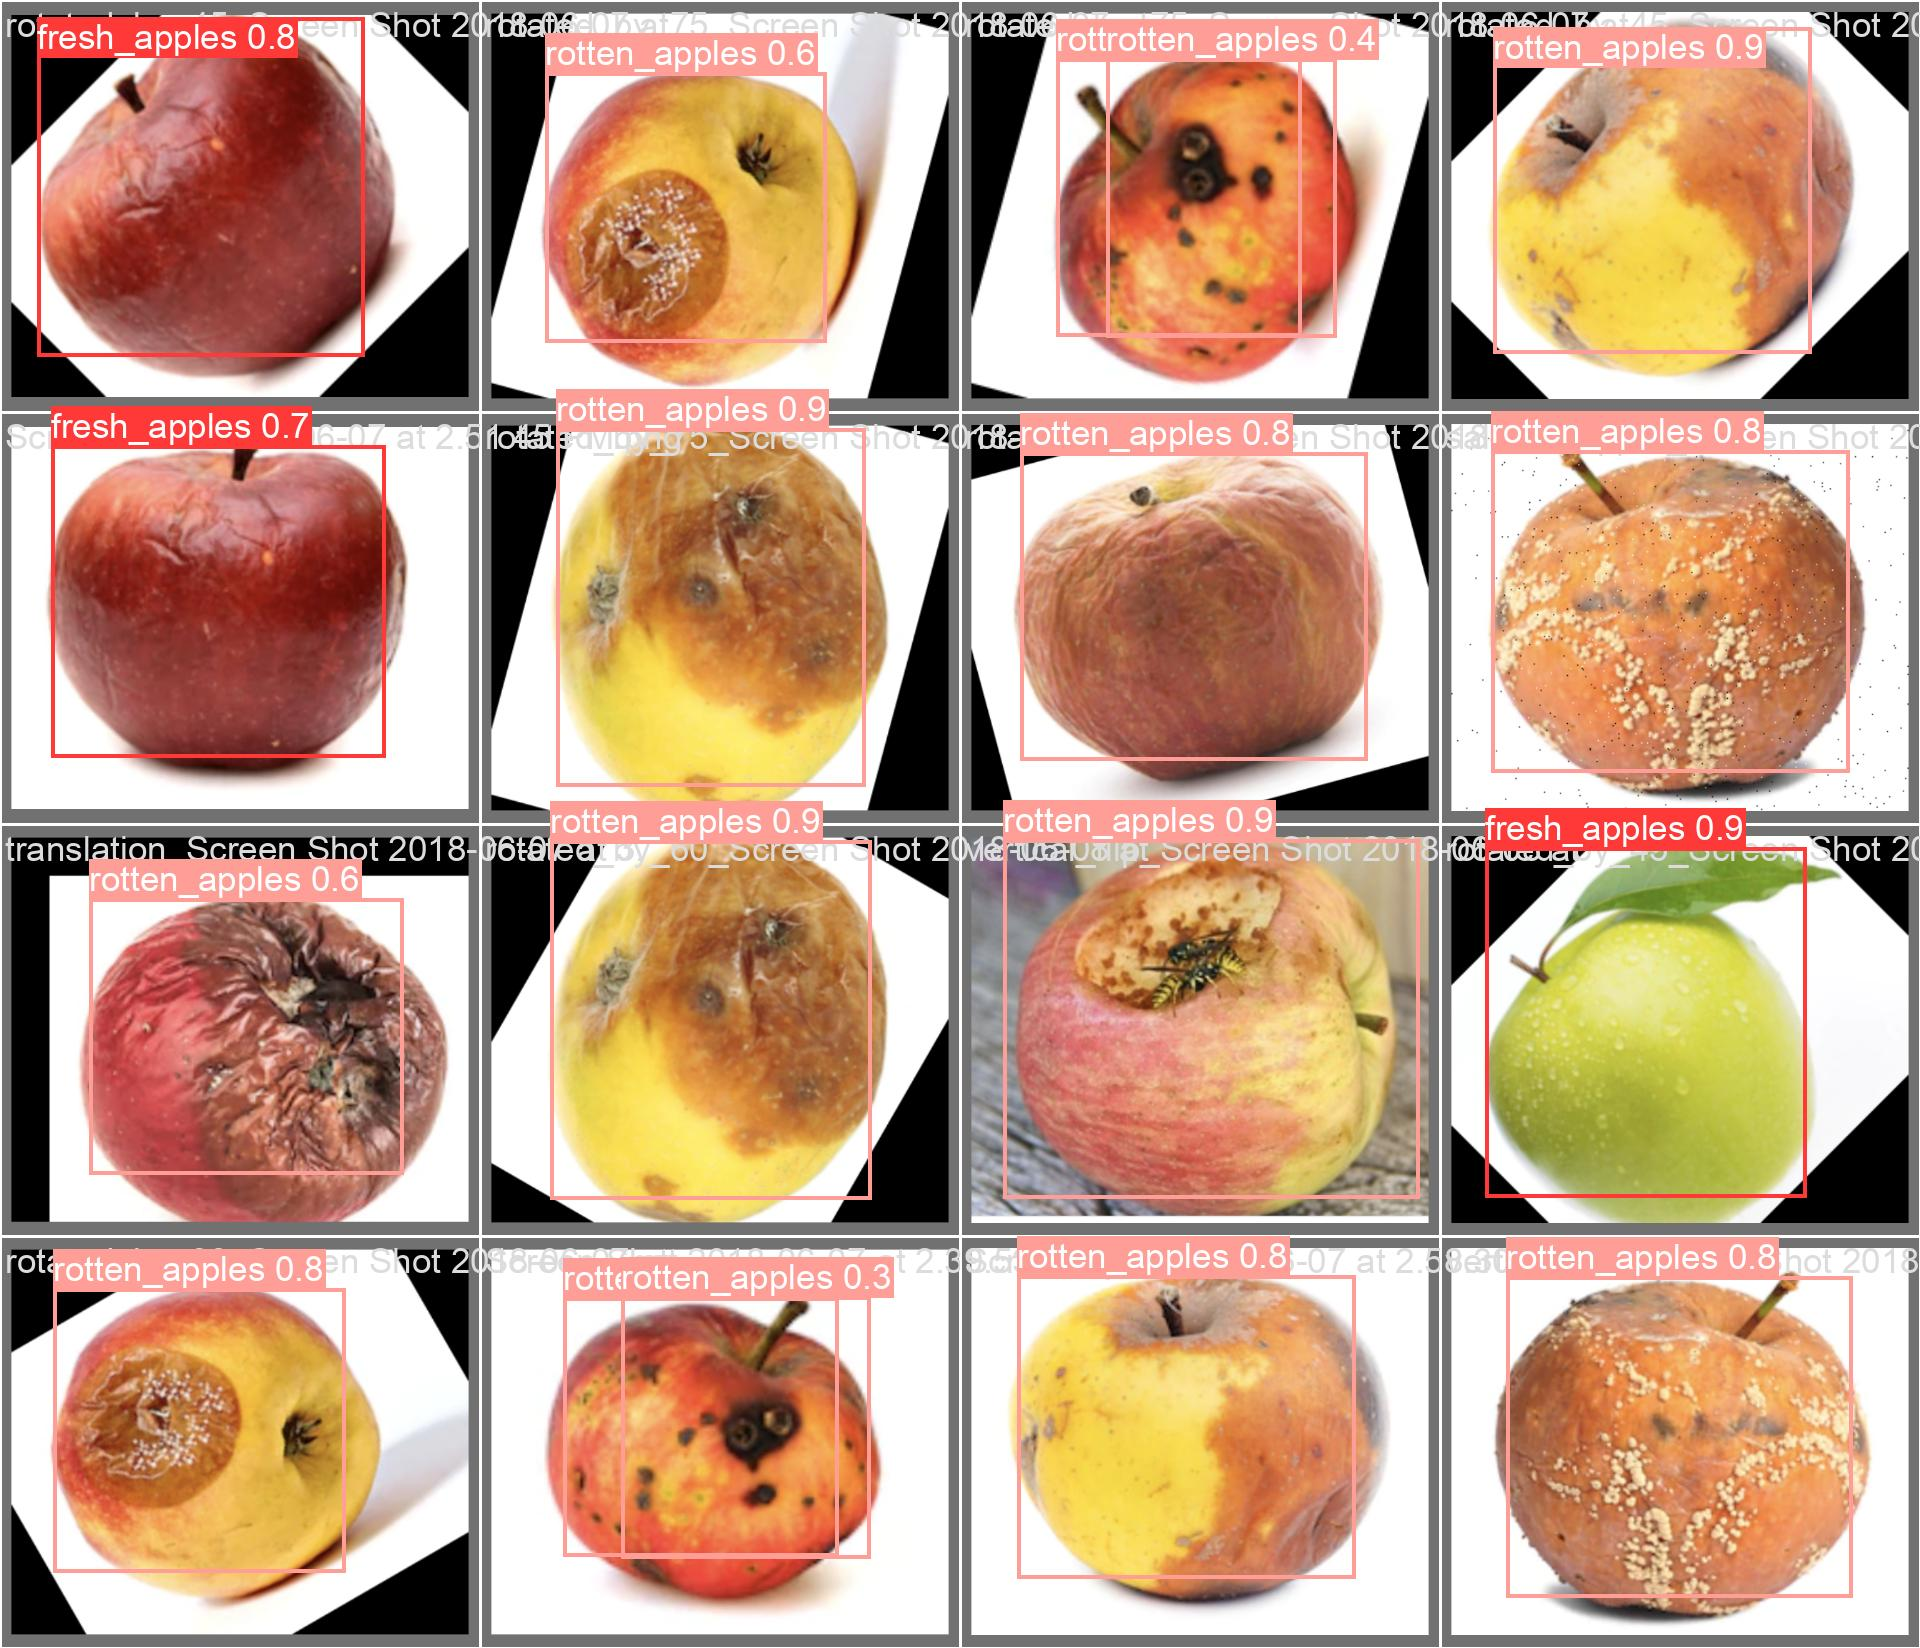

In [ ]:
Image(filename = '/content/runs/detect/train/val_batch2_pred.jpg')

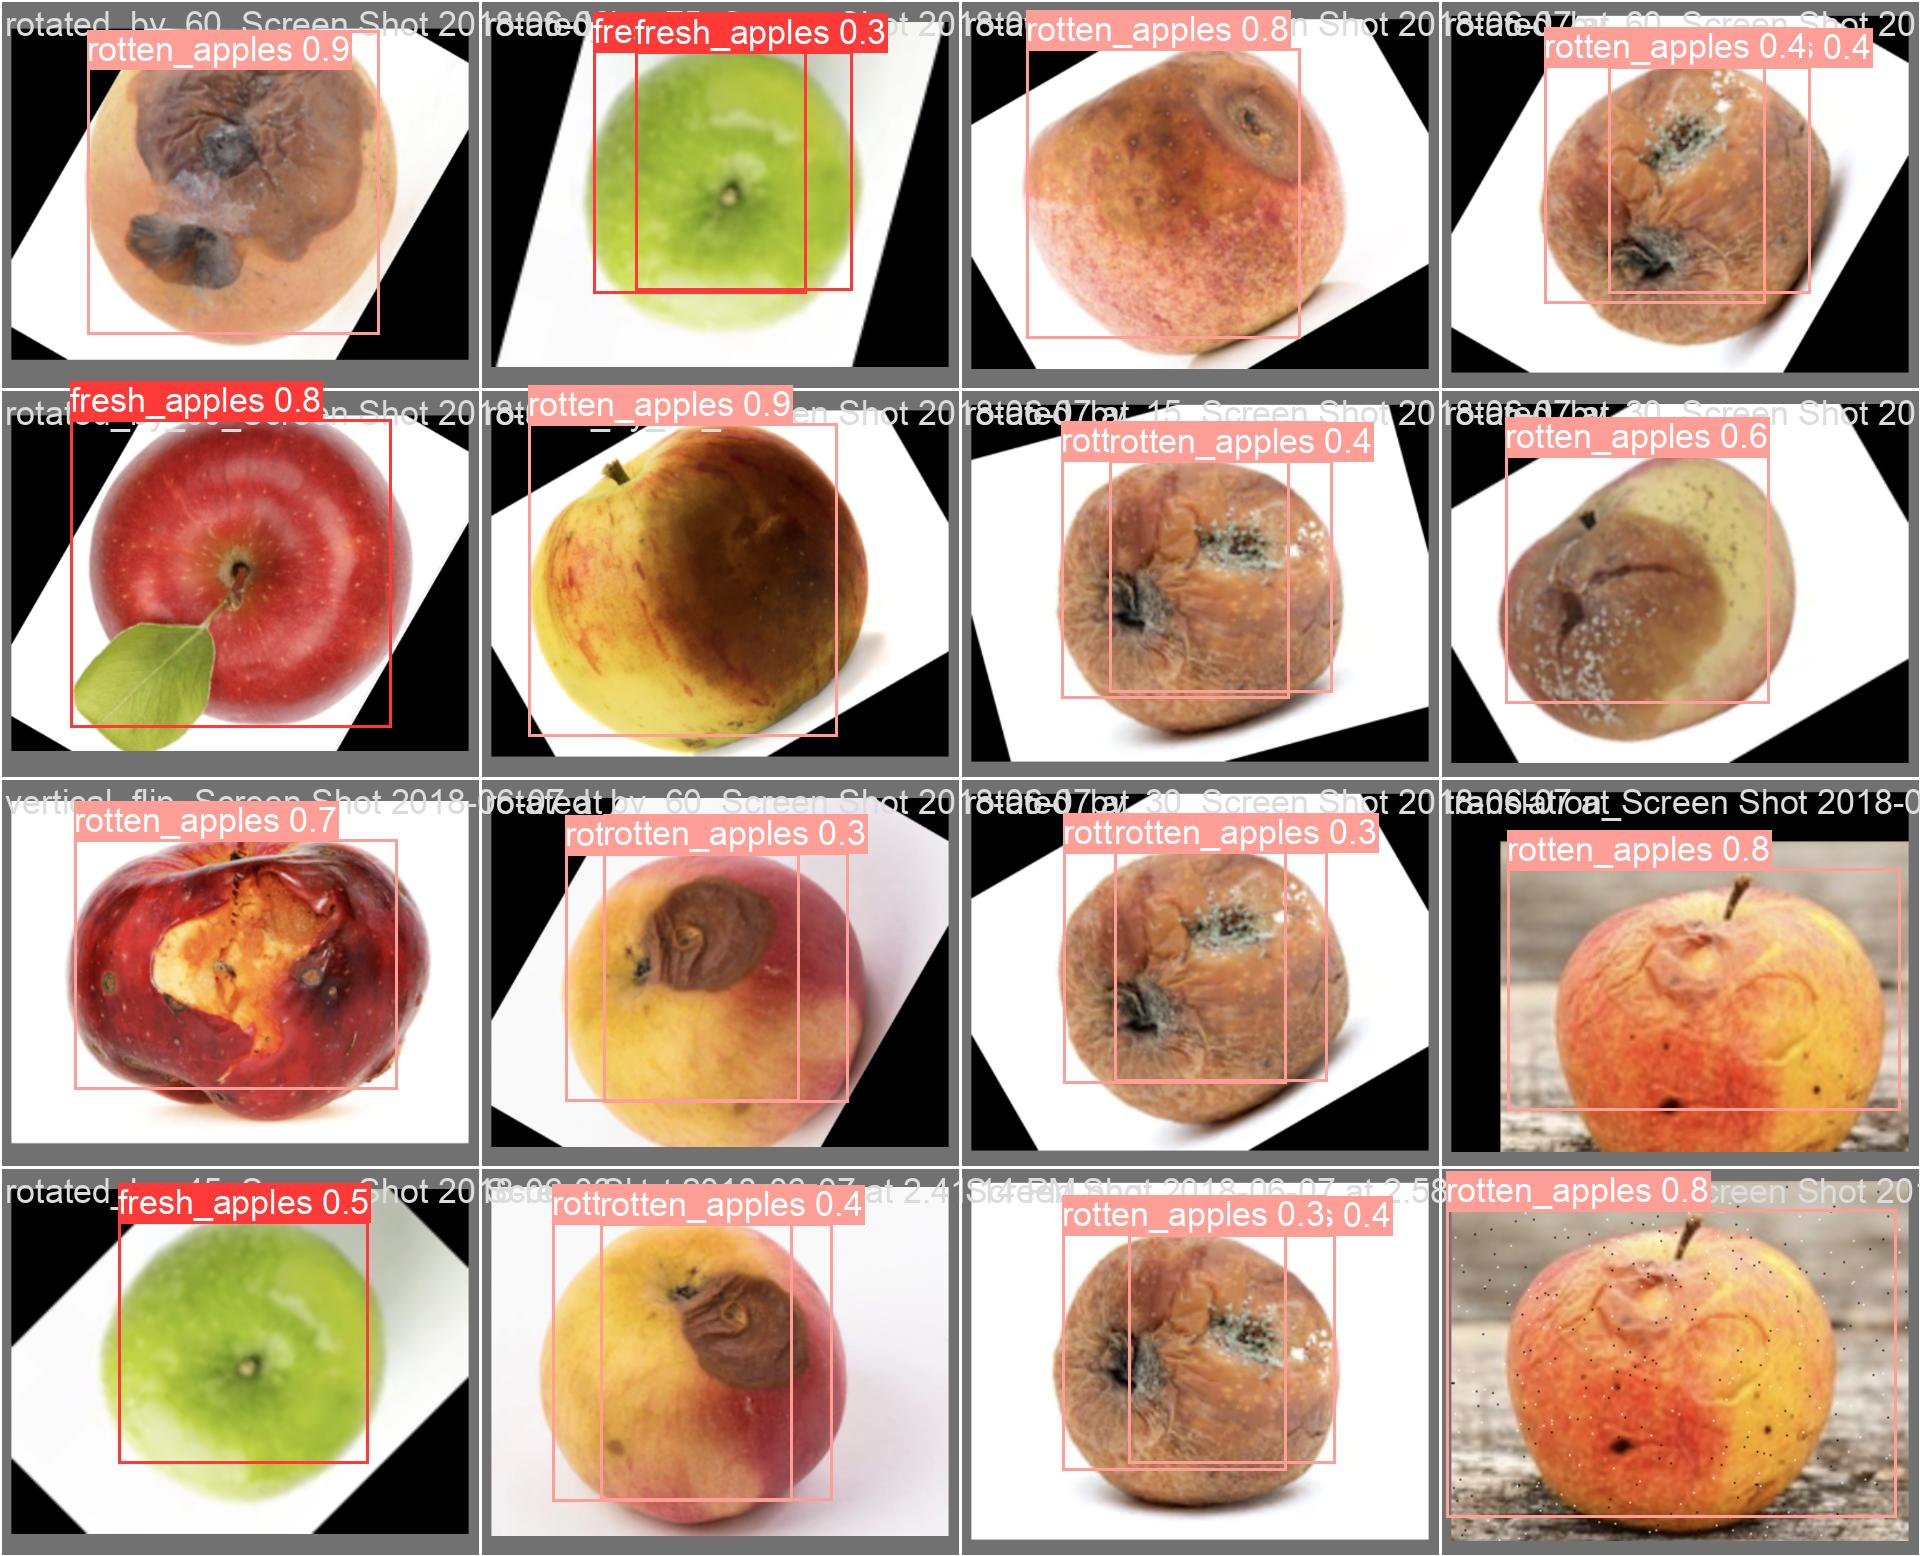

In [ ]:
Image(filename = '/content/runs/detect/train/val_batch0_pred.jpg')

In [ ]:
model = YOLO('/content/runs/detect/train/weights/best.pt')  # load a custom model

In [ ]:
# from google.colab import files
# files.download("/content/runs/detect/train/weights/best.pt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# import shutil

# # Source file path
# source_file = '/content/runs/detect/train/weights/best.pt'

# # Destination directory in Google Drive
# destination_dir = '/content/drive/My Drive/'

# # Copy the file to Google Drive
# shutil.copy(source_file, destination_dir)

'/content/drive/My Drive/best.pt'

In [ ]:
metrics = model.val()  # no arguments needed, dataset and settings remembered
metrics.top1   # top1 accuracy

Ultralytics YOLOv8.1.47 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 268 layers, 68125494 parameters, 0 gradients, 257.4 GFLOPs


val: Scanning /content/fresh_or_rotten/test/labels.cache... 996 images, 0 backgrounds, 0 corrupt: 100%|██████████| 996/996 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [01:07<00:00,  1.07s/it]


                   all        996        996      0.951       0.93      0.977      0.742
          fresh_apples        996        395      0.934      0.937      0.972       0.73
         rotten_apples        996        601      0.967      0.923      0.983      0.754
Speed: 0.3ms preprocess, 60.1ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs/detect/val2


AttributeError: 'DetMetrics' object has no attribute 'top1'. See valid attributes below.

    This class is a utility class for computing detection metrics such as precision, recall, and mean average precision
    (mAP) of an object detection model.

    Args:
        save_dir (Path): A path to the directory where the output plots will be saved. Defaults to current directory.
        plot (bool): A flag that indicates whether to plot precision-recall curves for each class. Defaults to False.
        on_plot (func): An optional callback to pass plots path and data when they are rendered. Defaults to None.
        names (tuple of str): A tuple of strings that represents the names of the classes. Defaults to an empty tuple.

    Attributes:
        save_dir (Path): A path to the directory where the output plots will be saved.
        plot (bool): A flag that indicates whether to plot the precision-recall curves for each class.
        on_plot (func): An optional callback to pass plots path and data when they are rendered.
        names (tuple of str): A tuple of strings that represents the names of the classes.
        box (Metric): An instance of the Metric class for storing the results of the detection metrics.
        speed (dict): A dictionary for storing the execution time of different parts of the detection process.

    Methods:
        process(tp, conf, pred_cls, target_cls): Updates the metric results with the latest batch of predictions.
        keys: Returns a list of keys for accessing the computed detection metrics.
        mean_results: Returns a list of mean values for the computed detection metrics.
        class_result(i): Returns a list of values for the computed detection metrics for a specific class.
        maps: Returns a dictionary of mean average precision (mAP) values for different IoU thresholds.
        fitness: Computes the fitness score based on the computed detection metrics.
        ap_class_index: Returns a list of class indices sorted by their average precision (AP) values.
        results_dict: Returns a dictionary that maps detection metric keys to their computed values.
        curves: TODO
        curves_results: TODO
    